In [ ]:
import os
os.system('pip install -U -r requirements.txt')

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import datetime
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


### Data from John Hopkins University
Data automatically updated everyday

In [3]:
# Fetch data

confirmed_df  = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df     = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_df        = confirmed_df.groupby(['Country/Region']).sum()
recoveries_df       = recoveries_df.groupby(['Country/Region']).sum()
deaths_df           = deaths_df.groupby(['Country/Region']).sum()

dates               = np.array([dt[:-3] for dt in confirmed_df.columns[2:]])

date_ticks     = np.arange(0, len(dates), 7) # interval of 7 days
date_labels    = dates[date_ticks]

print('Data available till:', confirmed_df.columns[-1])

Data available till: 4/17/20


### SIR (Susceptible-Infectious-Recovered) model for prediction 

Description of model https://www.youtube.com/watch?v=Qrp40ck3WpI



In [4]:
def sir_model_fitting(country, cluster_population=50000000, passed_data=0, show_plots=1, days_to_predict=10):
    """Fit SIR model and plot data vs model result for 90 days for comparison"""
    if passed_data:
        ydata   = country
        country = 'Worldwide (excluding China)' 
    else:
        confirmed          = np.array(confirmed_df.loc[country, confirmed_df.columns[2:]])
        recovered          = np.array(recoveries_df.loc[country, recoveries_df.columns[2:]])
        deaths             = np.array(deaths_df.loc[country, deaths_df.columns[2:]])
        ydata              = confirmed - recovered - deaths
        
    xdata = np.arange(len(ydata))+1
    days_to_predict = len(xdata) + days_to_predict
    ind   = np.where(ydata>0)[0][0]
    model_output = ydata[ind:]
    model_input = np.arange(len(model_output))

    inf0 = model_output[0]
    sus0 = cluster_population - inf0
    rec0 = 0

    def sir_model(y, x, beta, gamma):
        sus = -beta * y[0] * y[1]/cluster_population
        rec = gamma * y[1]
        inf = -(sus + rec)
        return sus, inf, rec

    def fit_odeint(x, beta, gamma):
        return odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

    popt, pcov = curve_fit(fit_odeint, model_input, model_output)
    fitted = fit_odeint(np.arange(days_to_predict-ind), *popt)
    fitted = np.append(np.zeros((ind,1)), fitted)

    if show_plots:
        fig = plt.figure()
        plt.plot(xdata, ydata, 'o')
        plt.plot(np.arange(len(fitted))+1, fitted)
        plt.plot([len(xdata), len(xdata)],[0, np.max(fitted)], ':k')
        plt.legend(['data', 'model prediction', "today we're here"])
        plt.title("SIR model fit to 'active cases' of " + country)
        plt.ylabel("Population infected")
        plt.xlabel("Days since 22 Jan 2020")
        plt.grid()

        print("Optimal parameters: beta =", round(popt[0],3), " gamma = ", round(popt[1],3))
    #     print('Goodness of fit', round(r2_score(ydata, fit_odeint(xdata, *popt)),4)*100, ' %')
        print('Optimal parameters Standard Dev: std_beta =', np.round(np.sqrt(pcov[0][0]),3), ' std_gamma =', np.round(np.sqrt(pcov[1][1]),3))
    else:
        return fitted


### Plotting function for countries

In [5]:
 def data_plot_country(country, show_plots=1): 
    confirmed          = np.array(confirmed_df.loc[country, confirmed_df.columns[2:]])
    recovered          = np.array(recoveries_df.loc[country, recoveries_df.columns[2:]])
    deaths             = np.array(deaths_df.loc[country, deaths_df.columns[2:]])
        
    if show_plots:
        fig = plt.figure()
        plt.stackplot(dates, confirmed - recovered - deaths, recovered, deaths, labels=['active cases', 'recovered','deaths'])
        plt.grid()
        plt.title('Cases in ' + country)
        plt.ylabel("# of cases")
        plt.xticks(date_ticks, date_labels)
        plt.legend(loc='upper left')
        print('Mortality rate:', round(deaths[-1]/confirmed[-1]*100,2), '%')
    
    return confirmed, recovered, deaths

## Situation in China
* The curve for total number of cases has plateaued and more people are coming out of the disease. 
* The overall situation in China has matured and it is a good model to look to for making inferences about other countries.  
* Although, the situation in China was limited to Hubei province but,its total population (58.5m) and land-mass size are comparable to some of the countries like **Italy and South Korea**.

Mortality rate: 5.53 %


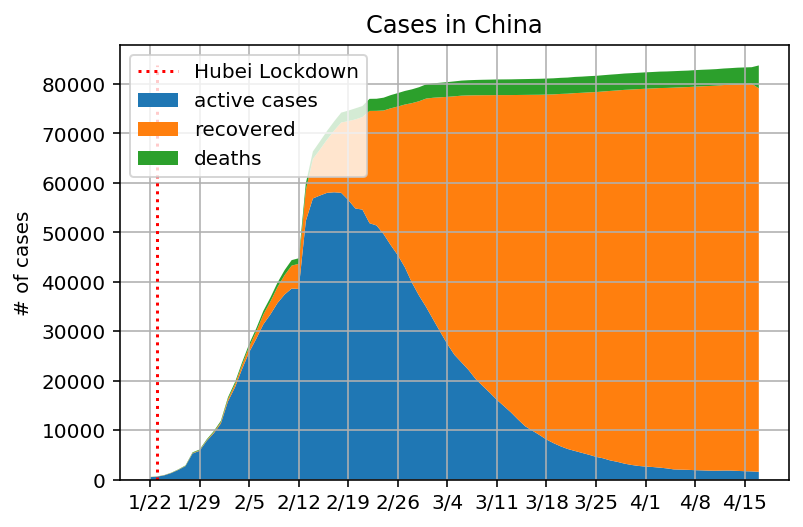

Optimal parameters: beta = 4.21  gamma =  3.996
Optimal parameters Standard Dev: std_beta = 0.07  std_gamma = 0.069


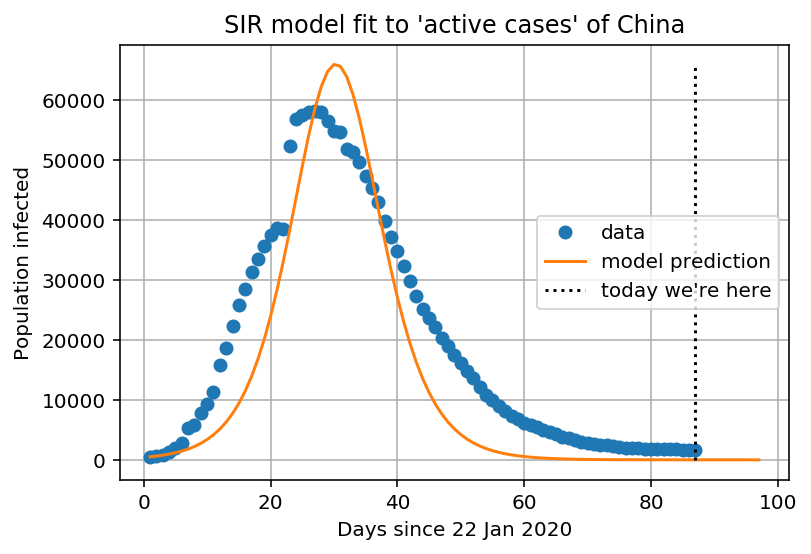

In [6]:
country= "China"
china_confirmed, china_recovered, china_fatalities  = data_plot_country(country)
plt.plot([1, 1], [0, np.max(china_confirmed)], ':r', label='Hubei Lockdown')
plt.legend(loc='upper left')
plt.show()

sir_model_fitting(country)

### South Korea
* South Korea was an interesting case in terms of both the infection spread and its containment.
* [Patient **31**](https://graphics.reuters.com/CHINA-HEALTH-SOUTHKOREA-CLUSTERS/0100B5G33SB/index.html) before whome the situation was very much contained, transmitted the infection to about 1000 people. It is a good reminder of why ***People with no symptoms*** should take social distancing seriously
* In terms of strategy to contain the spread, South Korea aggressively tested and tracked and isolated only the affected people instead of opting for area-wide lockdowns.

Mortality rate: 2.16 %


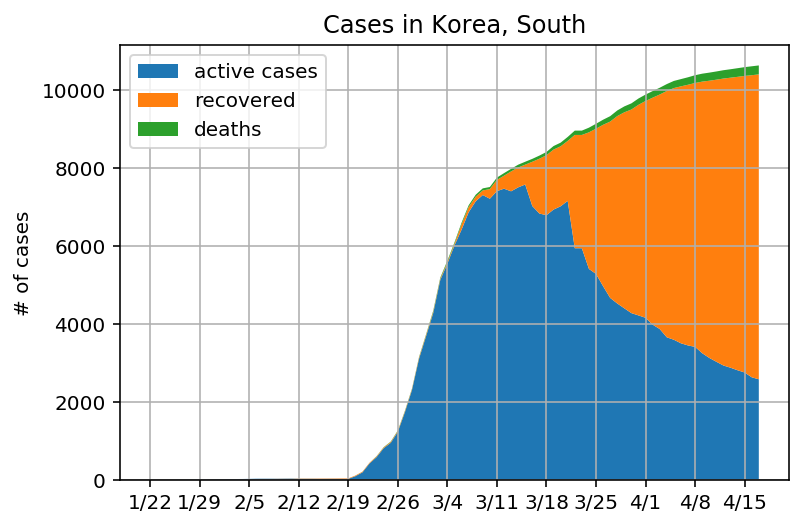

/var/mobile/Containers/Data/Application/5D65D1B0-B59F-4A2C-AAC6-CF4C18480EF9/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimal parameters: beta = 10.218  gamma =  10.025
Optimal parameters Standard Dev: std_beta = 0.301  std_gamma = 0.301


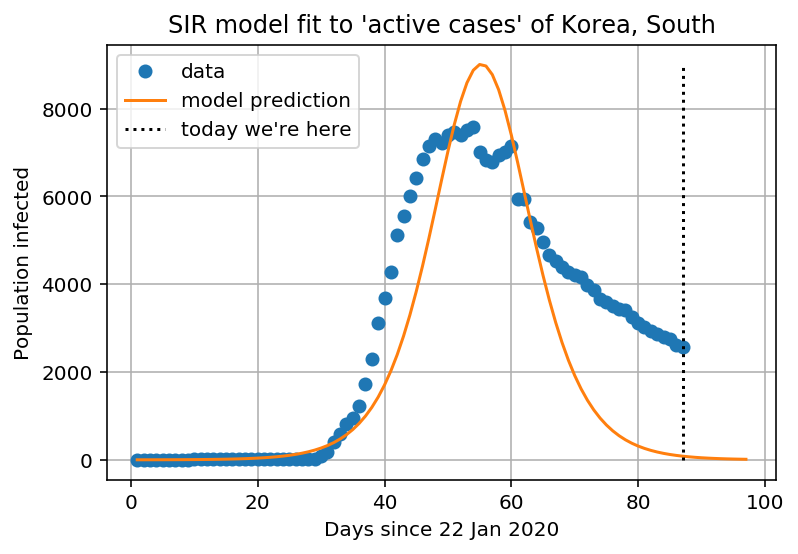

In [7]:
country= "Korea, South"
korea_confirmed, _,_  = data_plot_country(country)
plt.show()

sir_model_fitting(country)

## Worldwide situation
* The analysis of pooling all the data together has its drawbacks in the sense that it is hard to get an exact handle on the population of the world that is susceptible at once.
* Another drawback is that clusters of infection start at different times and they have access to immediate neighbourhood and can spread infections fast even if they start out small.
* This means one must look at individual big clusters (consider countries for now), and model their growth independent of other clusters.
* Adding up these growth projections can then give a fair estimate of Worldwide trend
* This prediction starts diverging from the one which uses aggregated data because if no measures are taken soon enough, then each cluster will spiral out of control. Resulting in explosion of number of cases around manyparts of the world.
* At this point it may be useful to consider the two approaches as upper and lower bounds of likely future scenarios.
* The overall data (including China) appears to consist of two part behaviour. Initial ***China phase*** and then ***World wide pandemic phase*** (WHO declared March 11).  
* Whereas number of cases (reported) outside China were significantly less until February, they exponentially grew since beginning of March and from there the World wide pandemic phase becomes more pronounced (China recovery and Italy and Iran numbers blowing up).  
* If identical measures like China were adopted somewhere around end of February, the worldwide cases could have plateaued in about the same time as China. Currently the numbers are significantly higher than China's when they implemented shutdown of Hubei (end of January).


/var/mobile/Containers/Data/Application/5D65D1B0-B59F-4A2C-AAC6-CF4C18480EF9/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
__main__:23: RuntimeWarning: overflow encountered in double_scalars
__main__:24: RuntimeWarning: overflow encountered in double_scalars
/var/mobile/Containers/Data/Application/5D65D1B0-B59F-4A2C-AAC6-CF4C18480EF9/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Error weight became zero during problem. Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


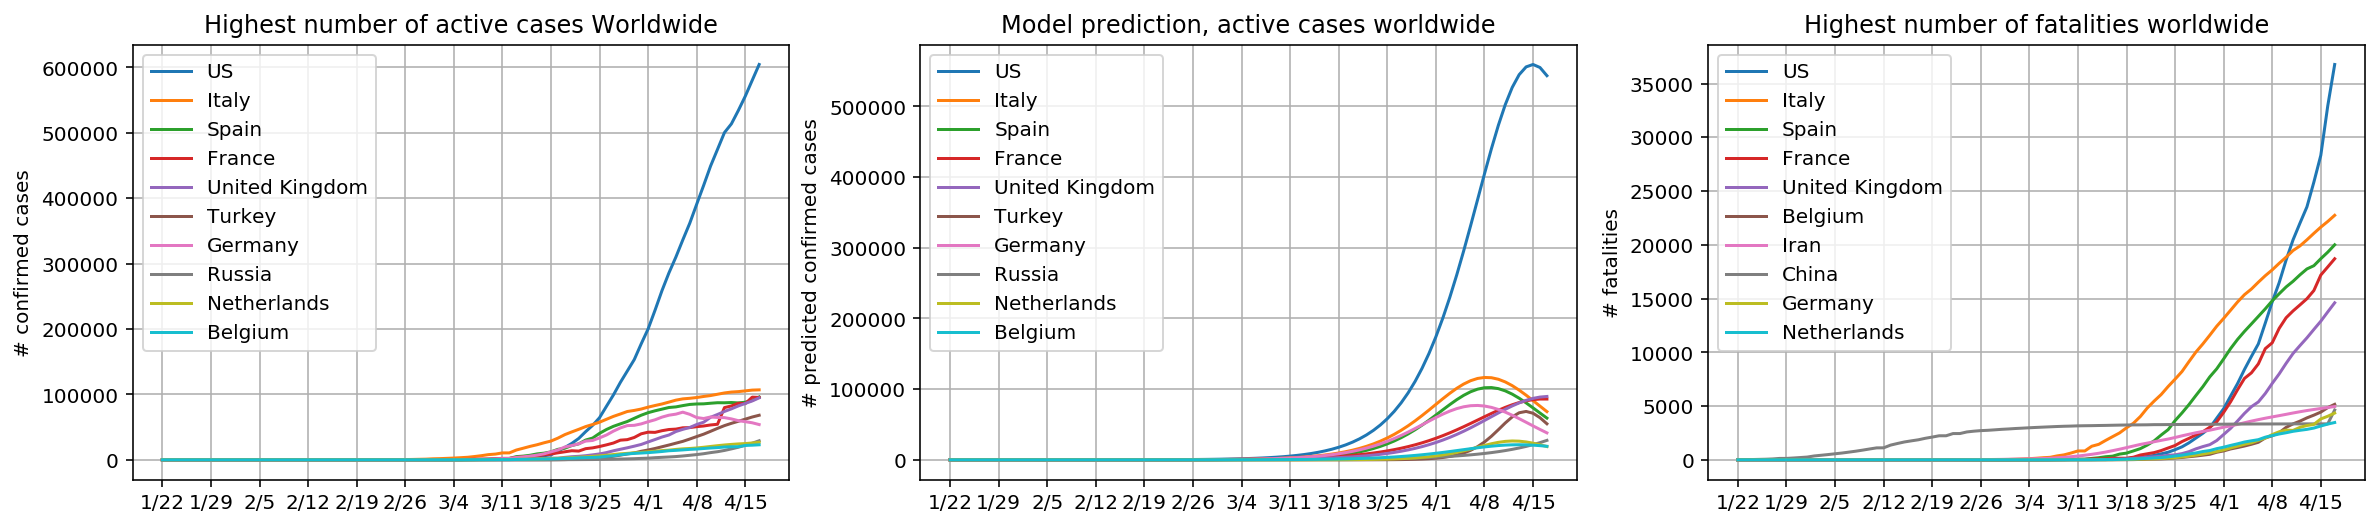

Total proportion of top countries in worldwide active cases  =  79.0 % 

Optimal parameters: beta = 0.447  gamma =  0.341
Optimal parameters Standard Dev: std_beta = 0.003  std_gamma = 0.004


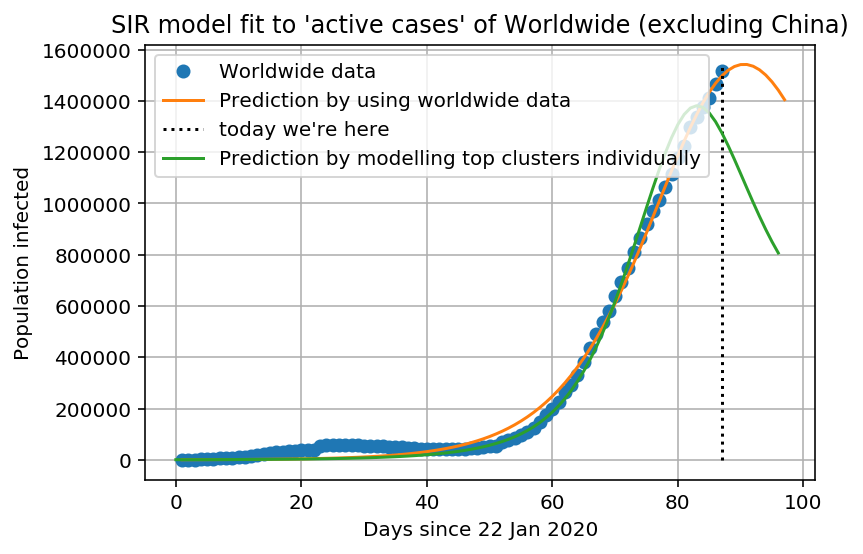

In [48]:
number_of_top_countries_of_interest = 10

worldwide_confirmed                 = confirmed_df.loc[:, confirmed_df.columns[2:]].sum(axis=0)
worldwide_recoveries                = recoveries_df.loc[:, confirmed_df.columns[2:]].sum(axis=0)
worldwide_fatalities                = deaths_df.loc[:, confirmed_df.columns[2:]].sum(axis=0)
worldwide_active_cases              = np.array(worldwide_confirmed - worldwide_recoveries - worldwide_fatalities)

top_confirmed_worldwide             = confirmed_df.loc[:, confirmed_df.columns[-1]] - recoveries_df.loc[:, recoveries_df.columns[-1]] - deaths_df.loc[:, deaths_df.columns[-1]]
top_confirmed_worldwide             = top_confirmed_worldwide.sort_values(ascending=False)[:number_of_top_countries_of_interest]

total_of_top_countries      = 0
confirmed_of_top_countries  = np.zeros((1, len(confirmed_df.columns[2:])))
recoveries_of_top_countries = np.zeros((1, len(recoveries_df.columns[2:])))
fatalities_of_top_countries = np.zeros((1, len(deaths_df.columns[2:])))

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
df = []
for country in top_confirmed_worldwide.index:
    data    = top_confirmed_worldwide[country]
    total_of_top_countries = total_of_top_countries + data
    confirmed_country, recoveries_country, fatalities_country = data_plot_country(country, show_plots=0)
    confirmed_of_top_countries    = confirmed_of_top_countries  + np.array(confirmed_country)
    recoveries_of_top_countries   = recoveries_of_top_countries + np.array(recoveries_country)
    fatalities_of_top_countries   = fatalities_of_top_countries + np.array(fatalities_country)
    ax[0].plot(dates, confirmed_country - recoveries_country - fatalities_country,label=country)
    country_fit = sir_model_fitting(country, show_plots=0, days_to_predict=10)
    df.append(country_fit)
    ax[1].plot(dates, country_fit[:-10], label=country)
    

ax[0].grid()
ax[0].set_title('Highest number of active cases Worldwide')
ax[0].set_ylabel("# confirmed cases")
ax[0].set_xticks(date_ticks)
ax[0].set_xticklabels(date_labels)
ax[0].legend()

ax[1].grid()
ax[1].set_title('Model prediction, active cases worldwide')
ax[1].set_ylabel("# predicted confirmed cases")
ax[1].set_xticks(date_ticks)
ax[1].set_xticklabels(date_labels)
ax[1].legend()


top_fatalities_worldwide    = deaths_df.loc[:, deaths_df.columns[-1]].sort_values(ascending=False)[:number_of_top_countries_of_interest]

for country in top_fatalities_worldwide.index:
#     data    = top_fatalities_except_china[country]
    _, _, fatalities_country = data_plot_country(country, show_plots=0)
    ax[2].plot(dates, fatalities_country,label=country)

ax[2].grid()
ax[2].set_title('Highest number of fatalities worldwide')
ax[2].set_ylabel("# fatalities")
ax[2].set_xticks(date_ticks)
ax[2].set_xticklabels(date_labels)
ax[2].legend()
plt.show()

total_proportion_of_top_countries = total_of_top_countries/worldwide_active_cases[-1]
print('Total proportion of top countries in worldwide active cases  = ', round(total_proportion_of_top_countries,2)*100, '% \n')


confirmed_non_top_countries      = np.array(worldwide_confirmed) - np.array(confirmed_of_top_countries[0])
recovered_non_top_countries      = np.array(worldwide_recoveries) - np.array(recoveries_of_top_countries[0])
fatalities_non_top_countries     = np.array(worldwide_fatalities) - np.array(fatalities_of_top_countries[0])
projection_non_top_countries     = sir_model_fitting(confirmed_non_top_countries -  recovered_non_top_countries - fatalities_non_top_countries, passed_data=1, cluster_population=50000000, show_plots=0)

# projection = np.sum(df, axis=0)/total_proportion_of_top_countries # Rough estimate using top countries data only
projection = np.sum(df, axis=0) + projection_non_top_countries

sir_model_fitting(worldwide_active_cases, passed_data=1, cluster_population=50000000)
plt.plot(projection)
plt.legend(['Worldwide data', 'Prediction by using worldwide data', "today we're here", 'Prediction by modelling top clusters individually'])
plt.show()


### India
* Having recently recorded its first few cases, the localised spread is starting to become dominant.
* A good thing about Indian scenario is government is taking proactive steps to ensure this can be contained. Whether it does or doesn't will be seen in coming few weeks.
* The data and consequently predictions reflect a scenario where no measures are in place. (sidenote: the model fit is very poor so far, more data in coming weeks can make it mroe accurate)

/var/mobile/Containers/Data/Application/5D65D1B0-B59F-4A2C-AAC6-CF4C18480EF9/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimal parameters: beta = 3.952  gamma =  3.827
Optimal parameters Standard Dev: std_beta = 0.233  std_gamma = 0.233


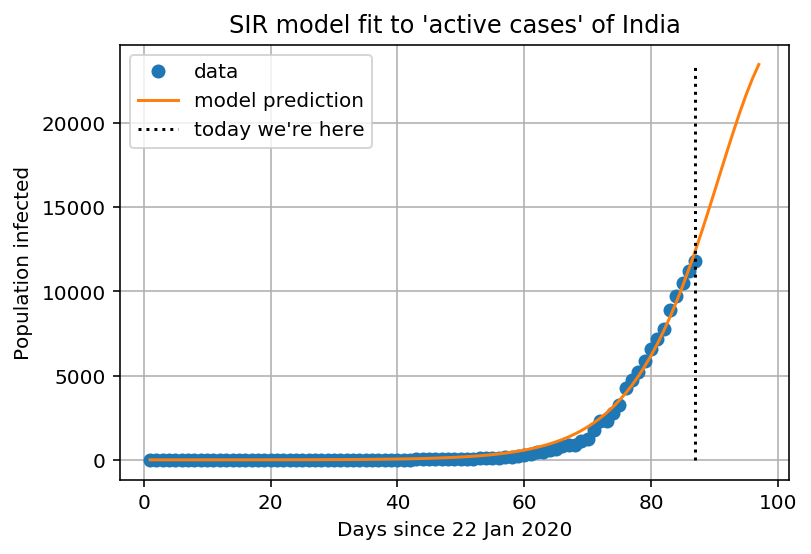

In [50]:
sir_model_fitting('India')

### United Kingdom

/var/mobile/Containers/Data/Application/5D65D1B0-B59F-4A2C-AAC6-CF4C18480EF9/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimal parameters: beta = 2.646  gamma =  2.489
Optimal parameters Standard Dev: std_beta = 0.015  std_gamma = 0.014


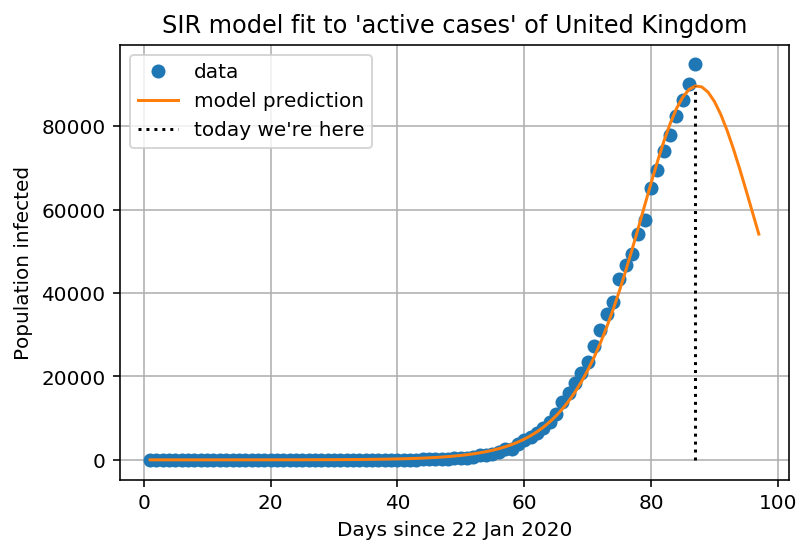

In [56]:
sir_model_fitting('United Kingdom')

## <p style='text-align: right;'> . . .  Work in progress </p>